# PV Power Readings Analysis

## Ideal Power Profile Curve

### Regression Function for Ideal Power Profile Curve

Once we have average power by sites in a zipcode every 15 minutes, we expect to build ideal power profile curve for each day. From data, one can see that, in general, plots of average power by sites for each day, are not ideal power profile curve. Yet some days have similar and simple bell-shape curves and high daily energy productions relative to neighbor days. Hence we make an assumption:

$\textbf{Assumption:}$ ideal power profile curves for each day have similar and simple bell-shape curves with high daily energy productions relative to neighbor days.

Here we import packages and read average power by components in a zipcode and pick a day of interest.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
%matplotlib inline

In [24]:
#specify data source 
datasource = 'L'

In [25]:
zipcode = '08641'

In [26]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'

data = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/'+ zipcode+'/training_data.csv')
metadata = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/'+ zipcode+'/training_metadata.csv',
                             dtype={'componentId':'object'})

#data = pd.read_csv(mainDir+ datasource + zipcode +'/trainingdata.csv')
#data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

(18000.0, 75600.0)

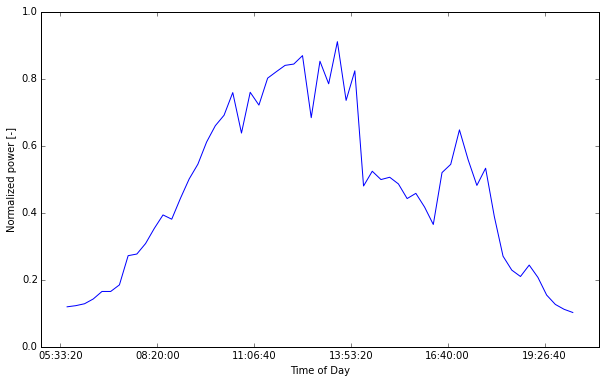

In [28]:
DateOfInterest = "2014-06-21" #21 #24 example for good days
df = data[data.tsLocal.map(lambda x: x[0:10]) == DateOfInterest]

fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(df.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").time()),df.power)
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Normalized power [-]')
ax1.set_ylim([0,1])
ax1.set_xlim([datetime.datetime.strptime(DateOfInterest +" 05:00:00","%Y-%m-%d %H:%M:%S").time(),\
              datetime.datetime.strptime(DateOfInterest +" 21:00:00","%Y-%m-%d %H:%M:%S").time()])
#plt.title('Average normalized power in zipcode ' + zipcode +'\n' +str(DateOfInterest))
#plt.show()

There are several choices of regression function to fit ideal power profile curves for each day. In order to agree with assumption above, we look for regression fuction with bell shape. The function value should be non-negative between sunrise and sunset. Here we assume that function value is zero elsewhere. That is, light scattering in atmosphere before sunrise or after sunset gives insignificant amount of power.  The promising candidate is linear combination of B-splines. 

Here we call a package to construct B-splines with certain number of knots and degree of function. We choose degree of basis function to be $2$ and choose 8 inner knots distributed as shown below. To accommodate possile bias on different edges, we should add basis functions of edges.

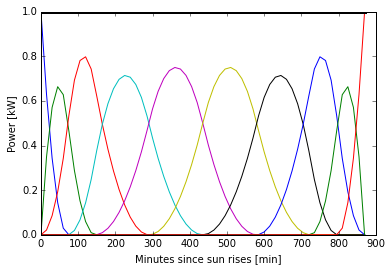

In [104]:
Ref = datetime.datetime.strptime(df.tsLocal.iloc[0],"%Y-%m-%d %H:%M:%S")
x = df.tsLocal.map(lambda x: (datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S") - Ref).total_seconds()/60)

#set up knots 
knots = [11*x.iloc[0]/12 + 1*x.iloc[-1]/12, 10*x.iloc[0]/12 + 2*x.iloc[-1]/12, 8*x.iloc[0]/12 + 4*x.iloc[-1]/12, 6*x.iloc[0]/12 + 6*x.iloc[-1]/12,
         4*x.iloc[0]/12 + 8*x.iloc[-1]/12, 2*x.iloc[0]/12 + 10*x.iloc[-1]/12, 1*x.iloc[0]/12 + 11*x.iloc[-1]/12]
#knots = [10*x.iloc[0]/12 + 2*x.iloc[-1]/12, 8*x.iloc[0]/12 + 4*x.iloc[-1]/12, 6*x.iloc[0]/12 + 6*x.iloc[-1]/12,
#         4*x.iloc[0]/12 + 8*x.iloc[-1]/12, 2*x.iloc[0]/12 + 10*x.iloc[-1]/12]

yy = patsy.dmatrix("bs(x, knots = knots, degree=2, include_intercept=True) - 1", {"x": x})
#remove last basis (non-zero at endpoint)
#y = np.delete(y,-1,1)
# Define some coefficients
b = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Plot B-spline basis functions (colored curves) each multiplied by its coeff
plt.plot(x, yy*b);

# Plot the spline itself (sum of the basis functions, thick black curve)
plt.plot(x, np.dot(yy, b), color='k', linewidth=3);
plt.xlabel('Minutes since sun rises [min]')
plt.ylabel('Power [kW]')

We run regression: $y=X\beta$ where $y$ is power reading, $X$ is attributes generated from spline basis, and $\beta$ is a set ofcoefficients associated with spline basis. We constraint $\beta$ to be non-negative. Such problem is called non-negative least square problem. We compute confidence interval based on formula:

$\beta^{*T} x \pm \kappa \sigma \sqrt{x^T (X^T X)^{-1} x }$

Note that this calculation is not completely accurate since we haven't imposed the effect on constraint on $\beta$ yet. In order to do find precise confidence interval, we may use bootstrap methods.

Here we would like to add an extra constant lift for splines as well.

In [105]:
X = np.matrix(yy)#np.concatenate((yy,np.matrix([1]*yy.shape[0]).T),axis=1)
y = df.power
import scipy
from scipy.optimize import nnls
beta = scipy.optimize.nnls(X,y)[0]
ypredict = np.dot(X,beta).T

from numpy.linalg import inv
import scipy as sp
import scipy.stats
confidence = 0.95
sigmasquare = np.dot(np.dot(X,beta)-y,(np.dot(X,beta)-y).T)/(len(y)-8-1)
kappa = sp.stats.t._ppf((1+confidence)/2., len(y)-8-1)
band = np.matrix(kappa*np.sqrt(np.diagonal(X*(np.linalg.inv(X.T*X)*X.T))*sigmasquare[0,0])).T

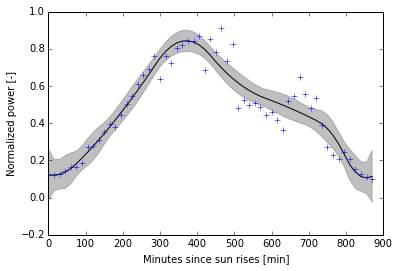

In [106]:
plt.plot(x, ypredict,color='black');
plt.plot(x,y,marker='+', ls='None')
plt.fill_between(x, np.array((ypredict-band).T.tolist()[0]), np.array((ypredict+band).T.tolist()[0]), color='grey', alpha='0.5')
plt.xlabel('Minutes since sun rises [min]')
plt.ylabel('Normalized power [-]')

### 1.2.2 2-dimensional grid representation and variable transformation

Let's look at power profile in grid representation. One way to visualize is to have hour of day and day of year as a grid. Then use colormap to represent power readings.

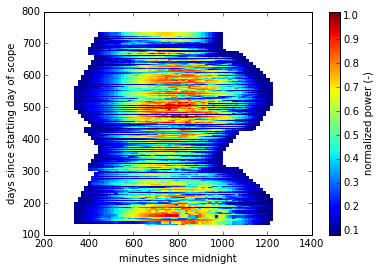

In [92]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
Ref = datetime.datetime.strptime(data.tsLocal.iloc[0],"%Y-%m-%d %H:%M:%S").date()
x = data.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour*60 \
                     + datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").minute)
y = data.tsLocal.map(lambda x: (datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date()-Ref).days)
plt.scatter(x, y, c= data.power, edgecolors='none',marker=',',s=20)
plt.xlabel('minutes since midnight')
plt.ylabel('days since starting day of scope')
cbar = plt.colorbar()
cbar.ax.set_ylabel('normalized power (-)')

One of disadventages in power profile regression above is that endpoints do not align. So we look into transformation from time of day to a variable from -1 to 1. This variable, called $s$, is cosine of angle on facial plane of an observer facing south.  Here we plot that variable on horizontal axis and power on vertical axis. -1 corresponds to sun rise and 1 corresponds to sun set.

-c:8: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


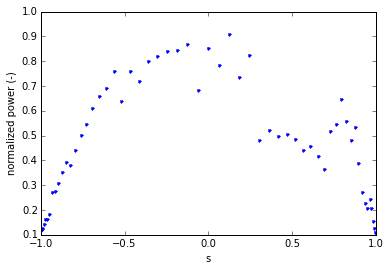

In [93]:
import math

DateOfInterest = "2014-06-21"
df = data[data.tsLocal.map(lambda x: x[0:10]) == DateOfInterest]
x = np.cos(df.azimuth/180*np.pi)*np.cos(df.altitude/180*np.pi)
y = np.sin(df.azimuth/180*np.pi)*np.cos(df.altitude/180*np.pi)
z = np.sin(df.altitude/180*np.pi)
df['s'] = -y/np.sqrt(y*y+z*z)
plt.plot(df.s,df.power, marker='.', ls='None')
plt.xlabel('s')
plt.ylabel('normalized power (-)')

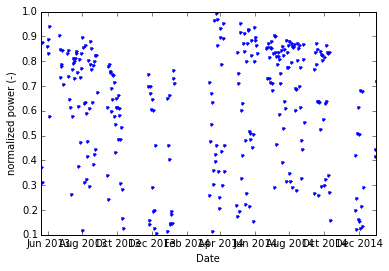

In [94]:
Ref = datetime.datetime.strptime(data.tsLocal.iloc[0],"%Y-%m-%d %H:%M:%S").date()
x = np.cos(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
y = np.sin(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
z = np.sin(data.altitude/180*np.pi)
data.s = y/np.sqrt(y*y+z*z)
df = data[(data.s >= 0.0) & (data.s <=.05)]
plt.plot(df.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date()),df.power,marker='.', ls='None')
plt.xlabel('Date')
plt.ylabel('normalized power (-)')

Here one can see that a slice of data, either through a day of year, or through a value of the variable. The power profile has desirable shapes. In a slice of data where the variable is fixed, the power profile may not be monotonic depending on orientations of panels. Now we can do 2d color map to show all power readings.

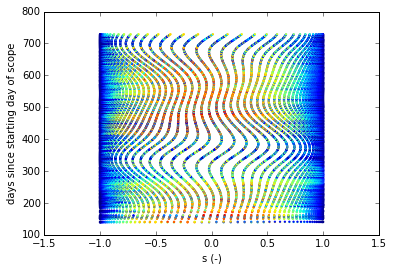

In [95]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab

x = np.cos(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
y = np.sin(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
z = np.sin(data.altitude/180*np.pi)
xx = y/np.sqrt(y*y+z*z)
yy = data.tsLocal.map(lambda x: (datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date()-Ref).days)
plt.scatter(xx, yy, c= data.power, edgecolors='none',s=5)
plt.xlabel('s (-)')
plt.ylabel('days since starting day of scope')
#ax.set_aspect('equal')
plt.show()

Now we implement splines with fixed knots independent of day.

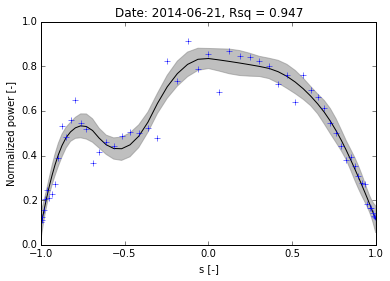

In [107]:
#set up knots 
knots = [-10./12, -8./12, -4./12, 0, 4./12, 8./12, 10./12]

DateOfInterest = "2014-06-21"
df = data[data.tsLocal.map(lambda x: x[0:10]) == DateOfInterest]
x = np.cos(df.azimuth/180*np.pi)*np.cos(df.altitude/180*np.pi)
y = np.sin(df.azimuth/180*np.pi)*np.cos(df.altitude/180*np.pi)
z = np.sin(df.altitude/180*np.pi)
df['s'] = y/np.sqrt(y*y+z*z)

x = df.s
yy = patsy.dmatrix("bs(x, knots = knots, degree=2, include_intercept=True,lower_bound=-1, upper_bound=1) - 1", {"x": x})
#remove last basis (non-zero at endpoint)
#y = np.delete(y,-1,1)

X = np.matrix(yy)#np.concatenate((yy,np.matrix([1]*yy.shape[0]).T),axis=1)
y = df.power
import scipy
from scipy.optimize import nnls
beta = scipy.optimize.nnls(X,y)[0]
ypredict = np.dot(X,beta).T

from numpy.linalg import inv
import scipy as sp
import scipy.stats
confidence = 0.95
sigmasquare = np.dot(np.dot(X,beta)-y,(np.dot(X,beta)-y).T)/(len(y)-8-1)
kappa = sp.stats.t._ppf((1+confidence)/2., len(y)-8-1)
band = np.matrix(kappa*np.sqrt(np.diagonal(X*(np.linalg.inv(X.T*X)*X.T))*sigmasquare[0,0])).T

Rsq = 1 - np.std(y-np.array((ypredict).T.tolist()[0]))*np.std(y-np.array((ypredict-band).T.tolist()[0]))/(np.std(y)*np.std(y))
plt.plot(x, ypredict,color='black');
plt.plot(x,y,marker='+', ls='None')
plt.fill_between(x, np.array((ypredict-band).T.tolist()[0]), np.array((ypredict+band).T.tolist()[0]), color='grey', alpha='0.5')
plt.xlabel('s [-]')
plt.ylabel('Normalized power [-]')
plt.title('Date: '+ DateOfInterest + ', Rsq = '+ str(Rsq)[0:5] )


Here one can see that such transformation works equally well.

Finally, one may try to spherical surface representation. However, slicing data with fixed azimuth or elevation angle is difficult to do. Moreover, it turns out that 2-dimensional spherical spline regression did not really give desirable ideal power reading curves since it has many saddles.

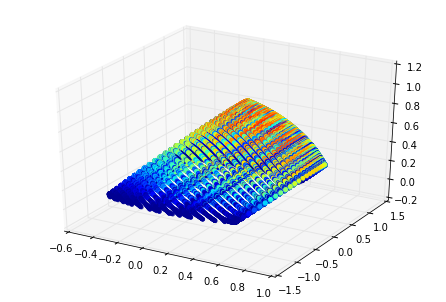

In [99]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab

fig = pylab.figure()
ax = Axes3D(fig)

x = np.cos(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
y = np.sin(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
z = np.sin(data.altitude/180*np.pi)
ax.scatter(x, y, z, c= data.power, edgecolors='none')
plt.show()